# Simulating infrared spectra of liquid water using NEP

## Introduction

In this tutorial, we will show you how to use the GPUMD package to simulate infrared spectra of water. For more details, please read our JCTC paper (J. Chem. Theory Comput. 2024, 20, 3273−3284). Citing our papers (J. Chem. Theory Comput. 2024, 20, 3273−3284; J. Phys. Chem. A 2024, 128, 2286−2294) is appreciated.

## Theoretical Background

The infrared spectrum for an isotropic system in equilibrium can be computed using linear response theory by Fourier transforming the total dipole moment autocorrelation function as:

$\sigma(\omega) \propto \omega^2 \int_{-\infty}^{\infty}
    \left< \vec{\mu}\left( 0 \right)\cdot \vec{\mu}\left( t \right) \right>
    e^{-i\omega t}\text{d}t\quad  (1)$         

To run MD simulations of liquid water, we use a ready-made NEP model trained by Dr. Ke Xu in his JCP paper (J. Chem. Phys. 2023, 158, 204114 ). The potential file can be accessed from the repository (https://gitlab.com/brucefan1983/nep-data/-/blob/main/2023_Xu_liquid_water/nep.txt). 
Rename it to `nep_pes.txt`.

Another NEP model trained with dipole data is required for the predictions of dipole moment ($\vec{\mu}$). We suggest that you refer to this tutorial to learn how to start a NEP dipole mode training (https://gpumd.org/tutorials/nep_dipole_tutorial.html). Details of training a NEP dipole mode are also available in our JCTC paper. Alternatively, you can download the `nep.txt` from the repository (https://zenodo.org/records/10257363/files/dipole_bulk_water.zip). Rename it to `nep_dipole.txt`. 

**In order to maintain maximum compatibility**, you need to open the nep_depole.txt file and change the keyword "nep4" to "nep4-dipole" in the first line, leaving everything else unchanged.  The keyword "nep4-dipole" would tell GPUMD that this is a model specifically trained for dipole.

## Run MD simulations and sample dipole moments

In this tutorial, we will output the real-time dipole moments of liquid water during MD simulations. For this purpose, four files: `model.xyz`, `run.in`, `nep_pes.txt` and`nep_pes.txt` are mandatory. The `model.xyz` contains the initial structure and the `run.in` file contains some parameters used for running MD simulations. 

### Prepare the `model.xyz` 

- The `model.xyz` should be in the format of `extented xyz` (https://gpumd.org/nep/input_files/train_test_xyz.html). Atomic labels, cartesian coordinates and lattices are needed in `model.xyz`. 

- You can create an initial water box using Packmol or Materials Studio. Alternative, you can build a water box using ASE (http://dcwww.camd.dtu.dk/~askhl/ase-doc/tutorials/tipnp_equil/tipnp_equil.html). Here, we use an orthogonal box of 216 water molecules.

### Prepare the `run.in` 

First, read the documentation (https://gpumd.org/gpumd/index.html) regarding input paramaters carefully. The water system was equilibrated in the NPT ensemble for 100 ps using the trained PES model (`nep_pes.txt`) at 298 K and 1 bar, followed by a further equilibration run in the NVT ensemble for another 100 ps. The production run was carried out in the NVE ensemble for a duration of 200 ps. A time step of 0.5 fs was used throughout.

```bash
potential   nep_pes.txt # Potential function for PES
potential   nep_dipole.txt # Potential function for dipole 
velocity    298.15 # Initial temperature set to 298.15 K
time_step   0.5 # Using 0.5 fs integration time step

# First relaxation with NPT ensemble at 298.15 K, 1 bar
ensemble    npt_ber 298.15 298.15 200 0.0001 2.2 2000
run         200000 # 100 ps

# Pre-equilibration in NVT ensemble
ensemble    nvt_bdp 298.15 298.15 200 
run         200000 # 100 ps

# Final sampling with NVE ensemble
ensemble    nve
dump_thermo 100 # Output thermodynamic quantities (T, P, etc.)
# we can output dipole moment on-the-fly.  
dump_dipole 2 # every 1 fs
# here we suppress the output of trajectories  
# dump_exyz   2 0 0 # Save configurations every 1 fs
run         400000 # 200 ps
```

In this tutorial, we can predict the dipole moment of system on-the-fly by using two NEP models. The first potential must be a regular NEP potential model (`nep_pes.txt`), whilst the second NEP should be a NEP dipole model (`nep_dipole.txt`). The dipole moment was sampled every 1 fs to capture the vibration frequency of hydroxyl groups.

### Run the `gpumd` executable

- Run the following command in the working directory

```bash
path/to/gpumd # if you use linux
path\to\gpumd # if you use Windows
```

It took about 1 hours to run the whole calculations using a GeForce RTX 3070. 

## Checking the `thermo.out` file

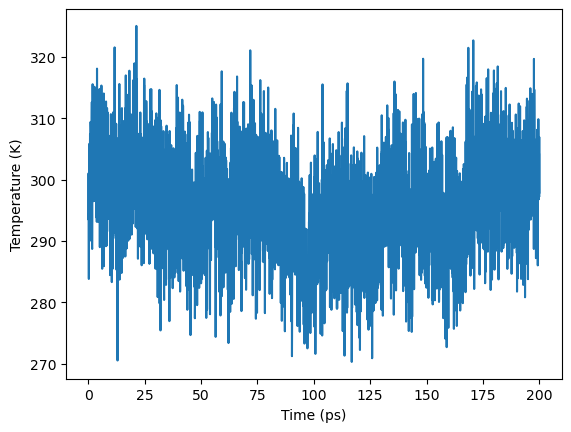

In [138]:
import numpy as np
import matplotlib.pyplot as plt
thermo = np.loadtxt("thermo.out")[:,:3]
time = np.arange(1,len(thermo)+1)*100*0.5/1000 
plt.plot(time,thermo[:,0])
plt.xlabel("Time (ps)")
plt.ylabel("Temperature (K)")
plt.show()

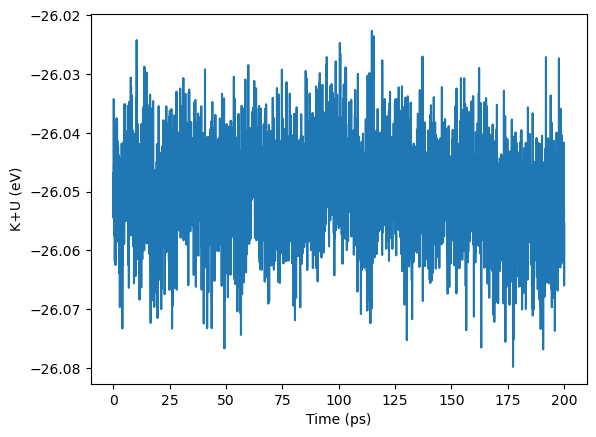

In [140]:
import numpy as np
import matplotlib.pyplot as plt
thermo = np.loadtxt("thermo.out")[:,:3]
time = np.arange(1,len(thermo)+1)*100*0.5/1000 
plt.plot(time,thermo[:,1]+thermo[:,2])
plt.xlabel("Time (ps)")
plt.ylabel("K+U (eV)")
plt.show()

In molecular dynamics simulations employing the microcanonical (NVE) ensemble, total energy fluctuations of 0.1% magnitude are statistically expected for finite-sized systems.

## Predicting IR intensites

The `dipole.out` file contains the dipole moments of the system in MD. The first column is step, and the second, third, and fourth columns are the three components of the dipole moment, respectively. By executing the following script, the infrared intensity will be obtained. **You should change the time interval firstly.** The dipole moment was sampled every 1 fs, therefore, time_interval shoud be 1 (unit:fs).


In [146]:
import numpy as np

time_interval = 1 #unit:fs

mu = np.loadtxt("dipole.out")[:,1:]
    
# use only the first 10% of the data for the correlation function, as the rest is not statistically meaningful 
Nmax=len(mu)//10 

def calc_corr_fft(mu, Nmax):
    n = len(mu)
    # Fill in data to make the length satisfy FFT properties
    padded_length = n + Nmax - 1
    padded_mu = np.zeros((padded_length, 3), dtype=mu.dtype)
    padded_mu[:n] = mu

    fft_result = np.fft.fft(padded_mu, axis=0)
    power_spectrum = np.abs(fft_result) ** 2
    autocorr = np.fft.ifft(power_spectrum, axis=0)

    # Take the real autocorrelation part
    autocorr = autocorr[:Nmax, :].real
    norm_factors = np.array([n - lag for lag in range(Nmax)]).reshape(-1, 1)
    autocorr /= norm_factors

    # Merge the results of three dimensions
    autocorr_flat = np.sum(autocorr, axis=1)
    return autocorr_flat / autocorr_flat[0]

def compute_power_spectrum(acf,Nmax):
    ir = np.zeros(Nmax)
    for k in range(Nmax):
        ir[k] = (acf*np.cos(2*np.pi*k*np.arange(0,Nmax,1)/(2*Nmax-1))).sum()    
    return ir
    
mean_value = mu.mean(axis=0)
correlation = calc_corr_fft(mu-mean_value,Nmax)

file_handle = open("dip_dip_correlation.time.txt",'w')
file_handle.write("# correlation in the time domain, first column time in fs\n")

for i in range(-Nmax+1,Nmax):
    file_handle.write("%f %f\n" %(i*time_interval,correlation[abs(i)]))
file_handle.close()

Kronecker_function = np.ones(Nmax) *2
Kronecker_function[0] = 1
Hann_window = (np.cos(np.pi*np.array(range(Nmax))/Nmax)+1)*0.5
correlation = correlation * Hann_window * Kronecker_function

cm_array = np.arange(0,Nmax,1)/((2*Nmax-1)*time_interval*10**(-15)*2.99792458*10**(10)) 
ir_intensity = compute_power_spectrum(correlation,Nmax)
data = np.array([cm_array,ir_intensity*cm_array**2]).T

def smooth_curve(x, k):
    window = np.ones(k) / k
    smoothed = np.convolve(x, window, mode='valid')
    return smoothed

np.savetxt("ir_original.txt",data)
# Smooth the curve
smoothed = smooth_curve(data[:,1], 10)
data = np.array([cm_array[:len(smoothed)],smoothed]).T
np.savetxt("ir_smooth.txt",data)

We can plot the IR intensities using data from `ir_smooth.txt`, which was smoothed to reduce noise.

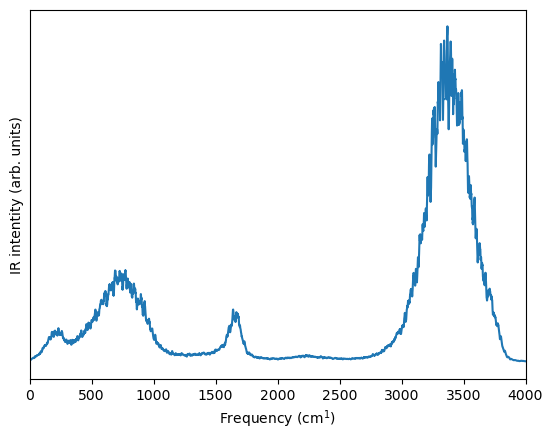

In [149]:
import numpy as np
import matplotlib.pyplot as plt
ir = np.loadtxt("ir_smooth.txt")
plt.plot(ir[:,0],ir[:,1])
plt.yticks([])
plt.xlim(0,4000)
plt.xlabel("Frequency (cm$^1$)")
plt.ylabel("IR intentity (arb. units)")
plt.show()

The figure is similar to Figure 4 in our JCTC paper. 

## Author 

Dr. Nan Xu

**Collaborative Opportunity**: Spectral simualtions (FTIR/Raman/THz) for catalytic, biomolecular, and quantum material systems.

Mail:tamas@zju.edu.cn